# Ensemble classifiers and Random Forest in particular

This week we'll look at some of the ensemble classifiers in scikit-learn.

We're going to train a RandomForestClassifier and an AdaBoost classifier. The first is a bagging classifier and the other is a boosted classifier.

First off, let's import the packages we want and load the data file as we have done previously. Then we'll take a look with `head()` to see if it looks ok.

**Remember to change `DATAFILE` below**

In [52]:
import sklearn as sk
import pandas as pd

DATAFILE = '/Users/990679/OneDrive - UTS/uni/teaching/IDA20S/lectures/week7/iris.csv'
iris = pd.read_csv(DATAFILE)

In [53]:
iris.head()

,Row,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


Let's now split the data into an `X` and `y` and then create a training and test split.

In [54]:
# Make the target numeric, and create training and test sets.
targets = iris['Species'].unique()
target2code = dict(zip(targets, range(len(targets))))

X = iris.iloc[:,1:-1] # strip off the row number and target.
y = iris.iloc[:,-1].copy() # don't want to overwrite the original 
y = y.apply(lambda x: target2code[x]) # convert each 

# Now split these into a training / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (105, 4)
y_train: (105,)
X_test: (45, 4)
y_test: (45,)


# Ensemble classifiers

There are several variants in scikit-learn. You can read about them here: https://scikit-learn.org/stable/modules/ensemble.html

They split into bagged vs boosted ensembles. Let's look at two variants:
* bagged decision trees - or random forests
* boosted decision trees - or AdaBoost

First we're going to use `sklearn.ensemble.RandomForestClassifier` because we want to do classification. We'll mostly just use the default parameters and then `fit` the data to the classifier. However, do look at the web page and have a play around.

Some attributes to pass to the classifier of interest are:
* `n_estimators` is the number of trees to build
* `max_features` controls the number of attributes to select from in each tree
* `oob_score=True` will get the classifier to calculate the out of bag score
* `class_weights` controls how to deal with unbalanced datasets


In [55]:
from sklearn.ensemble import RandomForestClassifier

# Construct a random forest classifier.
clf = RandomForestClassifier(n_estimators = 50, max_features="auto", oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, oob_score=True)

Let's look at the classifier, then look at the prediction for a particular point in the test set.

In [56]:
# We can print the classifier like this.
print(clf)

# The feature impartances can be accessed
print("Feature importances are:", clf.feature_importances_)

# oob score
print("oob score is {:.3f}".format(clf.oob_score_))

# Let's look at one specific prediction.
test_idx = 20
test_point = X_test.iloc[test_idx]

pred_test = clf.predict([test_point])
pred_test_probs = clf.predict_proba([test_point])

print("Testing point", test_idx, "; predicted as", pred_test[0],
      "; actually", y_test.iloc[test_idx], "; probabilities", pred_test_probs[0])

RandomForestClassifier(n_estimators=50, oob_score=True)
Feature importances are: [0.07317469 0.01549878 0.4118371  0.49948943]
oob score is 0.962
Testing point 20 ; predicted as 0 ; actually 0 ; probabilities [1. 0. 0.]


Like we did last week, let's make predictions for the test partition, print the classification report and the confusion matrix.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      0.91      0.87        11
           2       0.93      0.88      0.90        16

    accuracy                           0.93        45
   macro avg       0.92      0.93      0.92        45
weighted avg       0.94      0.93      0.93        45



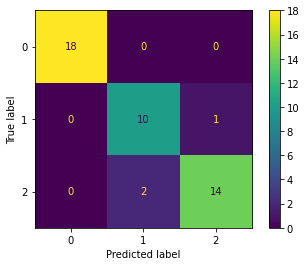

In [57]:
y_pred = clf.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test);

Finally, let's plot the ROC curve and work out the AUC value.

Because `iris` is a multi-class problem it's a bit trickier. We're goint to try to plot an ROC curve for each class (one vs the rest). First we need to work out the probabilities for the classes for each test point.

Then we use the `roc_auc_score` function to work out the AUC value.

Plotting the ROC curve is a bit more cumbersome. We need to loop over each class and then use the `roc_curve` function to return the TPRs and FPRs corresponding to a set of decision thresholds for that class vs the rest.

The AUC is 0.993


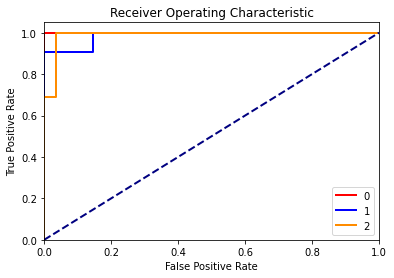

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the probabilities of each class.
y_probs = clf.predict_proba(X_test)

# The AUC score needs to be handled differently to get one number out of the three classes.
# We're going to average it over the three classes (one vs rest) weighted by the size of each
# class. The help gives the other option: ovo.
#auc = roc_auc_score(y_test, y_probs_class_1, multi_class="ovo", average="weighted")
auc = roc_auc_score(y_test, y_probs, multi_class="ovr", average="weighted")
print('The AUC is %.3f' % auc)

# Now let's plot the ROC curve.
import matplotlib.pyplot as plt
plt.figure()
col = { 0: "red", 1: "blue", 2:"darkorange"} # colour for each class
lw = 2 # the line width
# draw a line for each class (as the positive class)
for pos in range(3):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,pos], pos_label=pos)
    plt.plot(fpr, tpr, color=col[pos], lw=lw, label='%d' % pos)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Now let's train an AdaBoost classifier. Details on the classifier are at: https://scikit-learn.org/stable/modules/ensemble.html#adaboost

By default it makes an ensemble of decision stumps. We can set the number of trees in the ensemble using the `n_estimators` option. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      0.91      0.87        11
           2       0.93      0.88      0.90        16

    accuracy                           0.93        45
   macro avg       0.92      0.93      0.92        45
weighted avg       0.94      0.93      0.93        45

Feature importances are: [0.  0.  0.5 0.5]


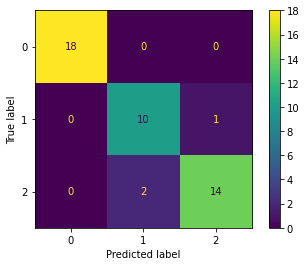

In [61]:
from sklearn.ensemble import AdaBoostClassifier

# Construct an AdaBoost classifier. 10 classifiers would be a very small number. 100+ is more
# typical.
clf = AdaBoostClassifier(n_estimators=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Output the performance
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

# The feature importances can be accessed
print("Feature importances are:", clf.feature_importances_)

plot_confusion_matrix(clf, X_test, y_test);
